### Libraries installing and import

In [1]:
!pip install python-binance
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scipy
!pip install scikit-learn

from binance.client import Client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# connection without specific keys, can only read spot data
client = Client() 

### Get data
Dataframe will have info about one coin, from binance exchange

In [2]:
def beautify(coin_historical_klines):
    coin_historical_klines=pd.DataFrame(coin_historical_klines)
    coin_historical_klines.columns=['TimeOpen', 'Open', 'High', 'Low', 'Close', 'Volume in Coin','TimeClose','Volume in $','# trades','coins marketbought', '$ spent to marketbuy', 'ignore']
    coin_historical_klines=coin_historical_klines.drop('ignore', axis=1)
    return coin_historical_klines

coin2_klines=client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1MINUTE, "5 minute ago UTC")
coin2_klines=beautify(coin2_klines)

### Learn data


In [3]:
print(coin2_klines.head())

        TimeOpen            Open            High             Low  \
0  1711605000000  69665.57000000  69734.69000000  69665.56000000   
1  1711605060000  69734.69000000  69734.69000000  69660.17000000   
2  1711605120000  69663.62000000  69666.82000000  69663.62000000   
3  1711605180000  69666.76000000  69666.76000000  69629.34000000   
4  1711605240000  69661.69000000  69677.48000000  69661.69000000   

            Close Volume in Coin      TimeClose       Volume in $  # trades  \
0  69734.68000000    18.05522000  1711605059999  1258680.10259750      1019   
1  69663.62000000    28.82365000  1711605119999  2008700.27441150      1301   
2  69666.76000000     4.74400000  1711605179999   330498.73753030       528   
3  69661.70000000    19.80198000  1711605239999  1379068.57349660       860   
4  69677.48000000     2.87628000  1711605299999   200378.42774780       241   

  coins marketbought $ spent to marketbuy  
0        13.38563000      933148.00255860  
1        16.38057000     114


#### Columns explanation

*TimeOpen* - starting time of the candlestick interval

*Open* - price at the beginning of the time interval

*High* - highest price reached during the time interval

*Low* - lowest price reached during the time interval

*Close* - price at the end of the time interval

*Volume in Coin* - total trading volume of the base (coin) cryptocurrency

*TimeClose* - ending time of the candlestick interval

*Volume in $* - total trading volume of the quote (usdt) cryptocurrency

*# trades* - total number of trades executed

*coins marketbought* - coins bought via marketorder = coins taken from market

*$ spent to marketbuy* - usdt spent to buy via marketorder = usdt given to market

*ignore* - not relevant for analysis, dropped

### Volume - Price

Since fair market is a combination of giant amount of random trades, price distribution is *stochastic*, in general. Means it moves randomly, but can be described with probability distributions. At different phases, distribution differ. They will be analyzed next.

#### Accumulation, Distribution, Flat

Accumulation - period, when base asset (coin) is taken from market by marketmakers.
Distribution - period, when base asset (coin) is given to market from marketmakers.
Flat - period, when price has low volatility. Usually happend at accumulation or distribution.

Flat - perfect example of stochastic property: price moves within some range, with some distribution, mostly affected by random trades = noise. Common assumption in statistics is fact that noise is distributed normally. Lets check it for cryptocurrencies market in flat period.

Hypothesis 0: Prices in flat are distributed normally

Hypothesis 1: Prices distributed not normally

Test via kolmogorov-smirnov.

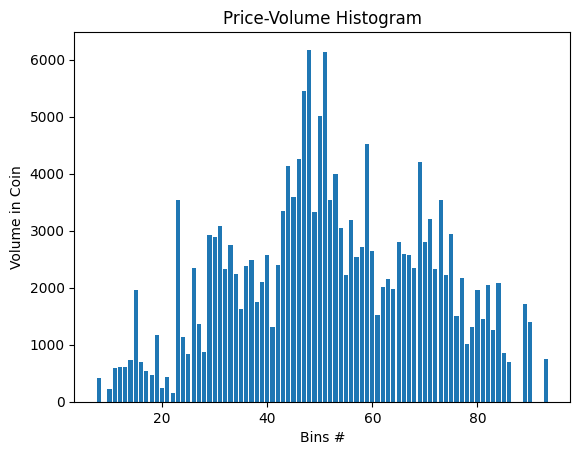

prices:  60364.7 63676.35


KstestResult(statistic=array([0.06445316]), pvalue=array([0.86782007]), statistic_location=array([0.52721812]), statistic_sign=array([1.]))

In [4]:
from scipy.stats import kstest
from scipy.stats import norm, expon

def bin_volume(coin_dataframe):
    coin_dataframe['Average Price'] = (coin_dataframe['Open'].astype(float) + coin_dataframe['Close'].astype(float)) / 2
    
    # Define bins based on min and max values of 'Low' and 'High' columns
    min_price = coin_dataframe['Low'].astype(float).min()
    max_price = coin_dataframe['High'].astype(float).max()
    bins = np.linspace(min_price, max_price, 101)  # 100 equally distributed bins, for kstest
    
    # Assign each row to a bin based on the average price
    coin_dataframe['Bin #'] = np.digitize(coin_dataframe['Average Price'], bins)
    
    # Group by bin and calculate the total volume in that bin
    coin_dataframe['Volume in Coin'] = coin_dataframe['Volume in Coin'].astype(float)
    total_volume_by_bin = coin_dataframe.groupby('Bin #')['Volume in Coin'].sum()
    return bins, total_volume_by_bin

#get data. This is last period of flat
btc_flat1=client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_5MINUTE, "29 Feb, 2024", "4 Mar, 2024")
btc_flat1=beautify(btc_flat1)
bins_prices, total_volume_by_bin=bin_volume(btc_flat1)

# plot volume - bin graph
plt.bar(total_volume_by_bin.index, total_volume_by_bin.values)
plt.xlabel('Bins #')
plt.ylabel('Volume in Coin')
plt.title('Price-Volume Histogram')
plt.show()
print("prices: ",bins_prices[0],bins_prices[-1])

# kolmogorov-smirnov test
flat_scaler = StandardScaler()
total_volume_by_bin_normalized = flat_scaler.fit_transform(total_volume_by_bin.values.reshape(-1,1))
kstest(total_volume_by_bin_normalized, norm.cdf)

We failed to reject H0 with pvalue=0.86. Also we see largest volume in middle and downtrend on both sides, with some outliers. Actually, this spikes are main factor of volatility - these are stoplosses/liqudations of traders. So, they always will exist in data. (Consider erase them?). < draw kde for fun >

This ineffectivity can be used as advantage in purpose to understand at which price trader should open his position (at extremums). 
A lot of traders do this mistake - they execute their plan with market order:
- with a high chance of being in majority (majority loses);
- not best entry price => less profit+higher loss => lower reward/risk ratio;
- their position will be in unrealised loss most of the time, because of market volatility.

#### Pump, dump, manipulation

During this high *volatility* period, market maker opens or closes his positions. In other words, when guy with big pockets whats to immidiatly buy or sell, large price movement is happened.

In this case, price distribution is highly depended on orderbook, which cannot be predicted *in advance*. Thus, probability distribution cannot be described properly. But still, when this volatility happening, it is possible to make good trades.

Lets check if it can be normal/chi-squared/exponential

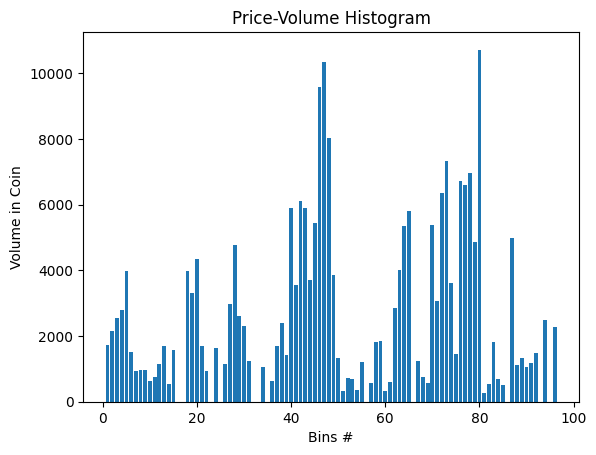

prices:  50901.44 64000.0
KstestResult(statistic=array([0.19108567]), pvalue=array([0.00368295]), statistic_location=array([-0.39986327]), statistic_sign=array([1.]))


In [5]:
btc_pump1=client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_5MINUTE, "26 Feb, 2024", "29 Feb, 2024")
btc_pump1=beautify(btc_pump1)
bins_prices, total_volume_by_bin=bin_volume(btc_pump1)

# plot volume - bin graph
plt.bar(total_volume_by_bin.index, total_volume_by_bin.values)
plt.xlabel('Bins #')
plt.ylabel('Volume in Coin')
plt.title('Price-Volume Histogram')
plt.show()
print("prices: ",bins_prices[0],bins_prices[-1])

# kolmogorov-smirnov test
total_volume_by_bin_normalized = flat_scaler.fit_transform(total_volume_by_bin.values.reshape(-1,1))
print(kstest(total_volume_by_bin_normalized, norm.cdf))

H0 rejected, data is not normally, nor exponentially distributed (0.00 pvalue), and in plot we see that also. Data is very spiky. 2 large values. So, we cannot say that this data is comes from some distribution.

### Volume - Volatility correlation

Btc market is fair market. By fair i mean there is no one marketmaker, just lots of traders and algorithms. Majority of other coins (altcoins) have one big marketmaker, and since he has largest portion of coins and money, price is mostly controlled by him.

Hypothesis: with large volatility, we have large volume, and vice versa. So, lets check, if this parameters are correlating on fair market, and on market with marketmaker. Consider low/high capitalisation coins.

#### High cap, no marketmaker (btc)

In [6]:
from scipy import stats
btc_3months=client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_4HOUR, "1 Dec, 2023", "1 Mar, 2024")
btc_3months=beautify(btc_3months)

btc_3months['max change in %']=abs(btc_3months['High'].astype(float)/btc_3months['Low'].astype(float)-1)*100
# Person correlation (consider feature value)
print(stats.pearsonr(btc_3months['max change in %'], btc_3months['Volume in Coin'].astype(float)))
print(stats.pearsonr(btc_3months['max change in %'], btc_3months['Volume in $'].astype(float)))
# Sperman correlation (consider just positive/negative change)
print(stats.spearmanr(btc_3months['max change in %'], btc_3months['Volume in Coin'].astype(float)))
print(stats.spearmanr(btc_3months['max change in %'], btc_3months['Volume in $'].astype(float)))

PearsonRResult(statistic=0.8829937889363658, pvalue=3.720594624346233e-181)
PearsonRResult(statistic=0.860272311879042, pvalue=1.4050912349431925e-161)
SignificanceResult(statistic=0.8778683585726644, pvalue=2.1101431221906727e-176)
SignificanceResult(statistic=0.8639756672423239, pvalue=1.5931677567685989e-164)


Indeed, high volatility is highly correlated with traded volume on fair market. Also correaltions have very same values between each other.

#### High cap, one marketmaker (trb)

In [7]:
trb_4months=client.get_historical_klines("TRBUSDT", Client.KLINE_INTERVAL_4HOUR, "1 Dec, 2023", "1 Mar, 2024") 
trb_4months=beautify(trb_4months)

trb_4months['max change in %']=abs(trb_4months['High'].astype(float)/trb_4months['Low'].astype(float)-1)*100

print(stats.pearsonr(trb_4months['max change in %'], trb_4months['Volume in Coin'].astype(float)))
print(stats.pearsonr(trb_4months['max change in %'], trb_4months['Volume in $'].astype(float)))

print(stats.spearmanr(trb_4months['max change in %'], trb_4months['Volume in Coin'].astype(float)))
print(stats.spearmanr(trb_4months['max change in %'], trb_4months['Volume in $'].astype(float)))

PearsonRResult(statistic=0.7039178251803742, pvalue=5.185772867728397e-83)
PearsonRResult(statistic=0.8480707858953533, pvalue=1.918103198237404e-152)
SignificanceResult(statistic=0.8603235393358023, pvalue=1.2809777484371878e-161)
SignificanceResult(statistic=0.8482834903523728, pvalue=1.3507706432083864e-152)


Here, we see, that correlation of 'volume in coin' is less than 'volume in $'. It can be explained by the fact, that this coin made +2900% in 4 months, and, the more coin cost, the less volume in that coin will be in future, though volume in usdt is same. Spearman correlation prove this.

#### Low cap, one marketmaker (ASR)

In [8]:
asr_4months=client.get_historical_klines("ASRUSDT", Client.KLINE_INTERVAL_4HOUR, "1 Dec, 2023", "1 Mar, 2024")
asr_4months=beautify(asr_4months)

asr_4months['max change in %']=abs(asr_4months['High'].astype(float)/asr_4months['Low'].astype(float)-1)*100

print(stats.pearsonr(asr_4months['max change in %'], asr_4months['Volume in Coin'].astype(float)))
print(stats.pearsonr(asr_4months['max change in %'], asr_4months['Volume in $'].astype(float)))

print(stats.spearmanr(asr_4months['max change in %'], asr_4months['Volume in Coin'].astype(float)))
print(stats.spearmanr(asr_4months['max change in %'], asr_4months['Volume in $'].astype(float)))

PearsonRResult(statistic=0.830087780201999, pvalue=2.365193969597473e-140)
PearsonRResult(statistic=0.8273520070104575, pvalue=1.2261923667955437e-138)
SignificanceResult(statistic=0.6966985961839451, pvalue=1.1687466544586725e-80)
SignificanceResult(statistic=0.69284549811405, pvalue=1.972522938080914e-79)


Volatility of this coin is much less, but still correaltions are strong.

#### Low cap, no marketmaker

There is no such

#### Abusing volume - price

Marketmaker need a lot of *liquidity* to open/close positions. Thats why they cant open their position without moving the price. So, with skill of detecting anomaly buy/sell and *vertical volume*, we can probably know what is the average position price of market maker.

Another fact: people dont want to lose money. Even theoretically. So marketmaker does. When price will go against him, he will do everything, to not be in losers. Somehow (another topic) price will go in his favor and he will back to profit. Here another inefectivity=advantage.

#### Conclusions

Hypothesis was true, Pearson correlation >0.8, spearman >=0.7 in every case state that there is strong correlation. Probably, trading algorithms are making this correlation so high. 

But why it not 1? When it happens so either large volume and low volatility, either low volume and high volatility? Answer, Inefecivities: high buy volume (Elon Musk make a tweet "Doge to the moon") can meet high resistance (Elon Musk sells doge) (high volume, low volatility).Or, nobody wants to sell, and its very cheap to move coin up (low volume, high volatility).

### Correlation between coins



#### market correlation to btc

The most famous cryptocurrency - bitcoin. But there is lots of others. And most of them correlate with bitcoin price.

In [9]:
def correlation_4hour(coin1,coin2):
    coin1_klines=client.get_historical_klines(coin1, Client.KLINE_INTERVAL_4HOUR, "29 Feb, 2024", "4 Mar, 2024")
    coin1_klines=beautify(coin1_klines)
    coin1_klines['price change in %']=(coin1_klines['Open'].astype(float)/coin1_klines['Close'].astype(float)-1)*100
    coin2_klines=client.get_historical_klines(coin2, Client.KLINE_INTERVAL_4HOUR, "29 Feb, 2024", "4 Mar, 2024")
    coin2_klines=beautify(coin2_klines)
    coin2_klines['price change in %']=(coin2_klines['Open'].astype(float)/coin2_klines['Close'].astype(float)-1)*100
    # want to know spearman just to see if there is movements in same direction
    print(stats.spearmanr(coin1_klines['price change in %'],coin2_klines['price change in %']))

def correlation_5min(coin1,coin2):
    coin1_klines=client.get_historical_klines(coin1, Client.KLINE_INTERVAL_5MINUTE, "1 day ago UTC")
    coin1_klines=beautify(coin1_klines)
    coin1_klines['price change in %']=(coin1_klines['Open'].astype(float)/coin1_klines['Close'].astype(float)-1)*100
    coin2_klines=client.get_historical_klines(coin2, Client.KLINE_INTERVAL_5MINUTE, "1 day ago UTC")
    coin2_klines=beautify(coin2_klines)
    coin2_klines['price change in %']=(coin2_klines['Open'].astype(float)/coin2_klines['Close'].astype(float)-1)*100
    # want to know spearman just to see if there is movements in same direction
    print(stats.spearmanr(coin1_klines['price change in %'],coin2_klines['price change in %']))

coins_to_check=['ETHUSDT','SOLUSDT','DOGEUSDT','PEPEUSDT']
for coin1 in coins_to_check:
    correlation_4hour(coin1,'BTCUSDT')
    correlation_5min (coin1,'BTCUSDT')

SignificanceResult(statistic=0.6938461538461538, pvalue=0.00011975873931514003)
SignificanceResult(statistic=0.8792529206804673, pvalue=4.140657392975309e-94)
SignificanceResult(statistic=0.3892307692307692, pvalue=0.05446248064417652)
SignificanceResult(statistic=0.7231724300589557, pvalue=6.97775762758258e-48)
SignificanceResult(statistic=0.41846153846153844, pvalue=0.03735881098217247)
SignificanceResult(statistic=0.6223783539552601, pvalue=2.8045295814675187e-32)
SignificanceResult(statistic=0.23153846153846153, pvalue=0.2654333714204926)
SignificanceResult(statistic=0.7690996318358815, pvalue=1.529884945470361e-57)


So, we take 4 large cap coins, and indeed, they correlate with btc moves.

As we see, most of coins have generally have 0.4-0.6% correlation. This again can be used in speculations. Every coins have different candlestick pattern. Sometimes this patterns are more structured than btc have and have higher probability of profit trade.

Also 5min correlation is much larger than 4hour, because of algorithms. 

#### L2,L3 correlation to L1

Also there is such thing as L2, L3 protocols, which based on L1 - blockchain itself. I.e. Polygon (MATIC) is based on Ethereium (ETH), and thus their price may correlate.

In [10]:
correlation_4hour('MATICUSDT','ETHUSDT')
correlation_5min ('MATICUSDT','ETHUSDT')
print("Maybe they correlate through btc?")
correlation_4hour('MATICUSDT','BTCUSDT')
correlation_5min ('MATICUSDT','BTCUSDT')
correlation_4hour('ETHUSDT','BTCUSDT')
correlation_5min ('ETHUSDT','BTCUSDT')

SignificanceResult(statistic=0.6784615384615386, pvalue=0.00019317889487445542)
SignificanceResult(statistic=0.8107466858448309, pvalue=1.7971324171771622e-68)
Maybe they correlate through btc?
SignificanceResult(statistic=0.45999999999999996, pvalue=0.020686192908586393)
SignificanceResult(statistic=0.7450956308729274, pvalue=3.105034116877746e-52)
SignificanceResult(statistic=0.6938461538461538, pvalue=0.00011975873931514003)
SignificanceResult(statistic=0.8792549300925536, pvalue=4.13143767341715e-94)


we see that correlation of matic/eth > matic/usdt. This is the expected result.

#### Price distribution of correlated coins

If coin movement is correlated, we can make a hypothesis

Hypothesis 0: price distributions between correlated coins is same, i.e. comes from one distribution

Hypothesis 1: price distributions between correlated is not same

Test via 2sample kolmogorov-smirnov.

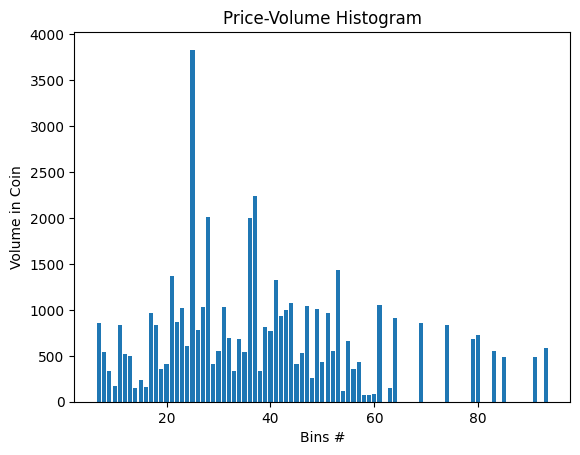

prices:  68359.18 71769.54


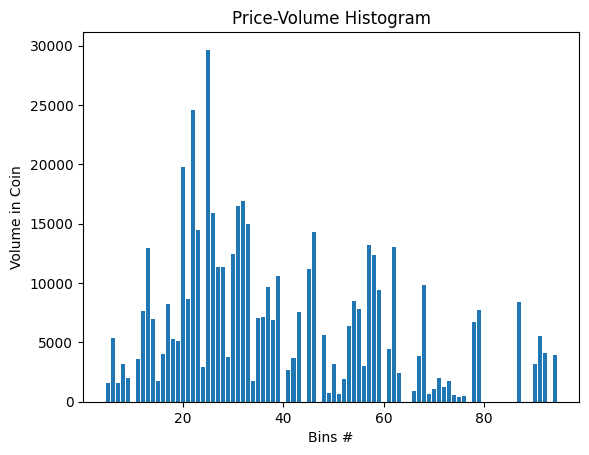

prices:  3460.02 3665.84
KstestResult(statistic=array([0.14230769]), pvalue=array([0.43985469]), statistic_location=array([0.54668733]), statistic_sign=array([1.]))


In [11]:
btc_klines=client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_5MINUTE, "1 day ago UTC")
btc_klines=beautify(btc_klines)
bins_prices_btc, total_volume_by_bin_btc=bin_volume(btc_klines)
# plot volume - bin graph
plt.bar(total_volume_by_bin_btc.index, total_volume_by_bin_btc.values)
plt.xlabel('Bins #')
plt.ylabel('Volume in Coin')
plt.title('Price-Volume Histogram')
plt.show()
print("prices: ",bins_prices_btc[0],bins_prices_btc[-1])

eth_klines=client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_5MINUTE, "1 day ago UTC")
eth_klines=beautify(eth_klines)
bins_prices_eth, total_volume_by_bin_eth=bin_volume(eth_klines)
# plot volume - bin graph
plt.bar(total_volume_by_bin_eth.index, total_volume_by_bin_eth.values)
plt.xlabel('Bins #')
plt.ylabel('Volume in Coin')
plt.title('Price-Volume Histogram')
plt.show()
print("prices: ",bins_prices_eth[0],bins_prices_eth[-1])

# kolmogorov-smirnov 2sample test
total_volume_by_bin_normalized_btc = flat_scaler.fit_transform(total_volume_by_bin_btc.values.reshape(-1,1))
total_volume_by_bin_normalized_eth = flat_scaler.fit_transform(total_volume_by_bin_eth.values.reshape(-1,1))
print(kstest(total_volume_by_bin_normalized_btc, total_volume_by_bin_normalized_eth))

test failed to reject null hypotheis(pvalue=0.44). In plots, we see that shape is very same. lower capitalisation coins have larger volatility, and have almost same movements as coin they correlate to, but different % change. This can be used in order to make portfolio more volatile

### Takeaways

1) Constantly increasing volume has direct effect on price, volatility on market
2) Previously found ineffectivities can help to find good price for speculations

Found inefectivities of market:
1) Price distribution in flat is normal
2) Large marketmaker position detected with volume analysis